# RBFE-Space v2: a workflow of generating a large number of ligand pairs to represent all RBFE transformations on a variety of ligand scaffolds

**Author: Jenke Scheen

* Adapted from FEGrow repository.

In [10]:
import copy

import prody
from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem

import fegrow
from fegrow import RGroups
import itertools
from glob import glob
from collections import Counter

from rdkit.Chem import Draw
from tqdm.notebook import tqdm
import csv

In [2]:
def getLigandSpace(core_structure, attachment_index):
    """Using an input scaffold molecule, generates 500 variations on it on the specified hydrogen index."""
    
    # get the FEgrow representation of the rdkit Mol.
    template_mol = fegrow.RMol(core_structure)
    
    # get all required R groups.
    groups = RGroups.dataframe
    selected_rgroups = groups["Mol"].values
    
    # build all analogs.
    AllChem.EmbedMolecule(template_mol, useRandomCoords=True)
    rmols = fegrow.build_molecules(template_mol, 
                               attachment_index, 
                               selected_rgroups)
    # get the SMILES for all analogs. 
    analog_smiles = rmols.GetSmiles()
    
    return [Chem.MolToSmiles(template_mol)] + analog_smiles

In [3]:
def getMCS(ligands):
    """Returns the MCS for a list of molecules using BSS-style flags."""
    ligands = [Chem.RemoveHs(mol) for mol in ligands]

    scaffold = Chem.MolFromSmarts(rdFMCS.FindMCS(ligands,
#                         atomCompare=rdFMCS.AtomCompare.CompareAny,
#                         bondCompare=rdFMCS.BondCompare.CompareAny,
#                         matchValences=False,
                        ringMatchesRingOnly=True,
                        completeRingsOnly=True,
#                         matchChiralTag=False,
                        timeout=5).smartsString)
    AllChem.Compute2DCoords(scaffold)

    return scaffold

In [4]:
def molWithAtomIdx(mol):

    Chem.rdDepictor.Compute2DCoords(mol)
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
        
    return mol

thrombin
[H]c1c([H])c([H])c(C([H])([H])C([H])(C(=O)N2C([H])([H])C([H])([H])C([H])([H])C2([H])C(=O)N([H])C([H])([H])c2c([H])c([H])c([H])c(Cl)c2[H])N([H])[H])c([H])c1[H]


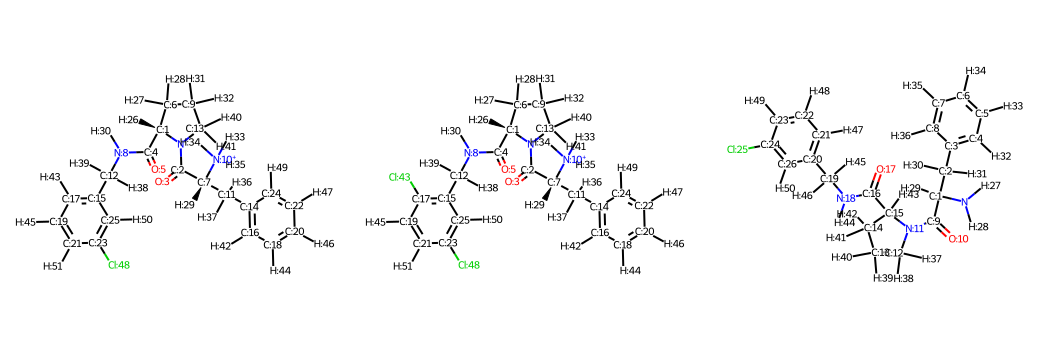

In [5]:
lig_folder = glob("../fep_ref_ligands/*")[10]
lig_series_name = lig_folder.split("/")[-1]
print(lig_series_name)

# get all ligands but keep only the first two. The MCS is ~ conserved across the series anyway.
ligs = [Chem.SDMolSupplier(lig, removeHs=False)[0] for lig in glob(f"{lig_folder}/*")]
ligs = [Chem.AddHs(lig) for lig in ligs[:2]]

# get the scaffold by MCS, then retrieve a molecule object by matching the MCS with one of the series' ligands.
core = getMCS(ligs)
# core.UpdatePropertyCache()
core = Chem.MolFromSmiles(Chem.MolToSmiles(core))
core = Chem.AddHs(core)
core_smiles = Chem.MolToSmiles(core)
print(core_smiles)

"""
The above was done manually for every ligand series. Annoyingly, some ligand series MCS works well with hydrogens,
whereas for other series it doesn't work (due to multiple reasons, mostly covalence issues in the MCS result). I
manually adjusted the MCS function per ligand series until I obtained a reasonable MCS. The MCS smiles was 
written down manually for inspection in the next cell - theattachment index (hydrogen) is found
manually per MCS in the next cell.

To reproduce:
1) adjust slice in top line of this cell to switch ligand series
2) run cell and inspect output structures
3) in case of rdkit error or poor MCS result; (un)comment the <Chem.RemoveHs(mol)> line in getMCS(ligands)
4) re-run this cell and check if happy with result
5) visually determine the correct hydrogen number and copy the MCS smiles for the series.
"""

"""
cdk8 : 25
[H]c1nn(C([H])([H])[H])c([H])c1-c1c([H])c([H])c(C([H])([H])c2nn([H])c3c([H])c([H])c(C(=O)N([H])[H])c([H])c23)c([H])c1[H]

pfkfb3 : 24
[H]c1nc2c([H])c(N([H])c3c([H])nc([H])c([H])c3[H])c([H])c(-c3c([H])c([H])c([H])c([H])c3[H])c2nc1[H]

shp2 : 32
[H]c1nc(-c2c([H])c([H])c([H])c(Cl)c2Cl)c(N([H])[H])nc1N1C([H])([H])C([H])([H])C(N([H])[H])(C([H])([H])[H])C([H])([H])C1([H])[H]

galectin : 47
[H]OC([H])([H])C1([H])OC([H])(Sc2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])C([H])(O[H])C([H])(n2nnc(-c3c(F)c(F)c([H])c(F)c3F)c2[H])C1([H])O[H]

mpro : 40
[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])c([H])c3C#N)c([H])c(-c3c([H])c([H])c([H])c(Cl)c3[H])c2=O)c([H])c1[H]
(taken from fegrow tutorial)

eg5 : 33
[H]c1c([H])c([H])c(C2([H])N([H])c3c([H])c([H])c(C([H])([H])[H])c([H])c3C3([H])OC([H])(C([H])([H])N([H])[H])C([H])([H])C([H])([H])C32[H])c([H])c1[H]

hif2a : 22
[H]OC1([H])c2c(c(Oc3c([H])c([H])c([H])c([H])c3[H])c([H])c([H])c2S([H])(=O)=O)C([H])([H])C1(F)F

cats : 45
[H]OC([H])(C([H])([H])N1C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])C1([H])[H])C([H])([H])n1nc(-c2c([H])c([H])c(C(F)(F)F)c(SC([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C(F)(F)C([H])([H])C3([H])[H])c2[H])c2c1C([H])([H])C([H])([H])N(S(=O)(=O)C([H])([H])[H])C2([H])[H]

cmet : 32
[H]c1c([H])c([H])c(C([H])([H])n2nc(-c3c([H])c(F)c([H])c(F)c3[H])c([H])c([H])c2=O)c([H])c1[H]

pde2 : 43
[H]c1nc([H])c(-c2nnc3c(C([H])([H])[H])nc4c([H])c([H])c(C([H])([H])N5C([H])([H])C([H])([H])OC([H])([H])C5([H])[H])c([H])c4n23)c([H])c1[H]

thrombin : 48
[H]c1c([H])c([H])c(C([H])([H])C([H])(C(=O)N2C([H])([H])C([H])([H])C([H])([H])C2([H])C(=O)N([H])C([H])([H])c2c([H])c([H])c([H])c(Cl)c2[H])N([H])[H])c([H])c1[H]

p38 : 26
[H]c1c([H])c([H])c(Oc2c([H])c3c([H])nc(N([H])C4([H])C([H])([H])C([H])([H])OC([H])([H])C4([H])[H])nc3n(C([H])([H])[H])c2=O)c([H])c1[H]

cdk2 : 45
[H]Oc1c([H])c([H])c(N([H])c2nc(OC([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c3nc([H])n([H])c3n2)c([H])c1[H]

bace : 19
[H]c1c([H])c(C([H])([H])[H])c([H])c(C2(C([H])([H])[H])N=C(N([H])[H])N(C([H])([H])[H])C2=O)c1[H]

mcl1 : 11
[H]c1c([H])c([H])c(OC([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c1[H]

syk : 22
[H]c1nc2c(N([H])c3c([H])c([H])c([H])c([H])c3[H])nc(-c3c([H])c([H])c([H])c([H])c3[H])c([H])n2c1[H]

ptp1b : 27
[H]OC(=O)c1sc(-c2c([H])c([H])c([H])c([H])c2[H])c(Br)c1OC([H])([H])C(=O)O[H]

tnks2 : 18
[H]c1c([H])c([H])c(-c2nc3c([H])c([H])c([H])c([H])c3c(=O)n2[H])c([H])c1[H]

tyk2 : 22
[H]C(=O)N([H])c1nc([H])c([H])c(N([H])C(=O)c2c(Cl)c([H])c([H])c([H])c2Cl)c1[H]

jnk1 : 23
[H]c1c([H])c([H])c(C([H])([H])C(=O)N([H])c2nc(OC([H])([H])C([H])([H])[H])c(C#N)c(N([H])[H])c2[H])c([H])c1[H]

"""
ligs += [core]
for lig in ligs:
    lig = molWithAtomIdx(lig)
Draw.MolsToGridImage(ligs[-6:], subImgSize=(350,350))




In [6]:
# now put in a dict.
MCS_results = {
    "cdk8" : [25, "[H]c1nn(C([H])([H])[H])c([H])c1-c1c([H])c([H])c(C([H])([H])c2nn([H])c3c([H])c([H])c(C(=O)N([H])[H])c([H])c23)c([H])c1[H]"],
    "pfkfb3" : [24, "[H]c1nc2c([H])c(N([H])c3c([H])nc([H])c([H])c3[H])c([H])c(-c3c([H])c([H])c([H])c([H])c3[H])c2nc1[H]"],
    "shp2" : [32, "[H]c1nc(-c2c([H])c([H])c([H])c(Cl)c2Cl)c(N([H])[H])nc1N1C([H])([H])C([H])([H])C(N([H])[H])(C([H])([H])[H])C([H])([H])C1([H])[H]"],
    "galectin" : [47, "[H]OC([H])([H])C1([H])OC([H])(Sc2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])C([H])(O[H])C([H])(n2nnc(-c3c(F)c(F)c([H])c(F)c3F)c2[H])C1([H])O[H]"],
    "mpro" : [40, "[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])c([H])c3C#N)c([H])c(-c3c([H])c([H])c([H])c(Cl)c3[H])c2=O)c([H])c1[H]"],
    "eg5" : [33, "[H]c1c([H])c([H])c(C2([H])N([H])c3c([H])c([H])c(C([H])([H])[H])c([H])c3C3([H])OC([H])(C([H])([H])N([H])[H])C([H])([H])C([H])([H])C32[H])c([H])c1[H]"],
    "hif2a" : [22, "[H]OC1([H])c2c(c(Oc3c([H])c([H])c([H])c([H])c3[H])c([H])c([H])c2S([H])(=O)=O)C([H])([H])C1(F)F"],
    "cats" : [45, "[H]OC([H])(C([H])([H])N1C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])C1([H])[H])C([H])([H])n1nc(-c2c([H])c([H])c(C(F)(F)F)c(SC([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C(F)(F)C([H])([H])C3([H])[H])c2[H])c2c1C([H])([H])C([H])([H])N(S(=O)(=O)C([H])([H])[H])C2([H])[H]"],
    "cmet" : [32, "[H]c1c([H])c([H])c(C([H])([H])n2nc(-c3c([H])c(F)c([H])c(F)c3[H])c([H])c([H])c2=O)c([H])c1[H]"],
    "pde2" : [43, "[H]c1nc([H])c(-c2nnc3c(C([H])([H])[H])nc4c([H])c([H])c(C([H])([H])N5C([H])([H])C([H])([H])OC([H])([H])C5([H])[H])c([H])c4n23)c([H])c1[H]"],
    "thrombin" : [48, "[H]c1c([H])c([H])c(C([H])([H])C([H])(C(=O)N2C([H])([H])C([H])([H])C([H])([H])C2([H])C(=O)N([H])C([H])([H])c2c([H])c([H])c([H])c(Cl)c2[H])N([H])[H])c([H])c1[H]"],
    "p38" : [26, "[H]c1c([H])c([H])c(Oc2c([H])c3c([H])nc(N([H])C4([H])C([H])([H])C([H])([H])OC([H])([H])C4([H])[H])nc3n(C([H])([H])[H])c2=O)c([H])c1[H]"],
    "cdk2" : [45, "[H]Oc1c([H])c([H])c(N([H])c2nc(OC([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c3nc([H])n([H])c3n2)c([H])c1[H]"],
    "bace" : [19, "[H]c1c([H])c(C([H])([H])[H])c([H])c(C2(C([H])([H])[H])N=C(N([H])[H])N(C([H])([H])[H])C2=O)c1[H]"],
    "mcl1" : [11, "[H]c1c([H])c([H])c(OC([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c1[H]"],
    "syk" : [22, "[H]c1nc2c(N([H])c3c([H])c([H])c([H])c([H])c3[H])nc(-c3c([H])c([H])c([H])c([H])c3[H])c([H])n2c1[H]"],
    "ptp1b" : [27, "[H]OC(=O)c1sc(-c2c([H])c([H])c([H])c([H])c2[H])c(Br)c1OC([H])([H])C(=O)O[H]"],
    "tnks2" : [18, "[H]c1c([H])c([H])c(-c2nc3c([H])c([H])c([H])c([H])c3c(=O)n2[H])c([H])c1[H]"],
    "tyk2" : [22, "[H]C(=O)N([H])c1nc([H])c([H])c(N([H])C(=O)c2c(Cl)c([H])c([H])c([H])c2Cl)c1[H]"],
    "jnk1" : [23, "[H]c1c([H])c([H])c(C([H])([H])C(=O)N([H])c2nc(OC([H])([H])C([H])([H])[H])c(C#N)c(N([H])[H])c2[H])c([H])c1[H]"],
}

In [25]:
lig_folders = glob("../fep_ref_ligands/*")

for lig_folder in lig_folders:
    lig_series_name = lig_folder.split("/")[-1]
    print(lig_series_name)
    
    #### get the 500 analogs of the MCS that we made for this ligand series as well as the actual MCS mol, i.e. n=501.
    attach_index, MCS = MCS_results[lig_series_name]
    MCS = Chem.AddHs(Chem.MolFromSmiles(MCS))
    analog_space = getLigandSpace(MCS, [attach_index])
    
    # write all 501*500/2 combinations to a file.
    pairs = itertools.combinations(analog_space, 2)
    with open(f"database/{lig_series_name}_grown.csv", "w") as writefile:
        writer = csv.writer(writefile)
        for pair in tqdm(pairs, total=int((len(analog_space)*(len(analog_space)-1))/2)):
            writer.writerow(pair)
            
            
    
    #### we also want to have all pairs of ligands in the original ligand series. 
    ligs = [Chem.SDMolSupplier(lig, removeHs=False)[0] for lig in glob(f"{lig_folder}/*.sdf")]
    ligs = [Chem.AddHs(lig) for lig in ligs]
    ligs_smiles = [Chem.MolToSmiles(lig) for lig in ligs]
    
    # do the same as for the growing approach, i.e. write all combinations to a file.
    pairs = itertools.combinations(ligs_smiles, 2)
    with open(f"database/{lig_series_name}_from_ref.csv", "w") as writefile:
        writer = csv.writer(writefile)
        for pair in tqdm(pairs, total=int((len(ligs_smiles)*(len(ligs_smiles)-1))/2)):
            writer.writerow(pair)

    

cdk8


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

pfkfb3


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/780 [00:00<?, ?it/s]

shp2


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

galectin


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

mpro


  0%|          | 0/125250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

eg5


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

hif2a


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/861 [00:00<?, ?it/s]

cats


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/741 [00:00<?, ?it/s]

cmet


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

pde2


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

thrombin


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

p38


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

cdk2


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

bace


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

mcl1


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/861 [00:00<?, ?it/s]

syk


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/946 [00:00<?, ?it/s]

ptp1b


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

tnks2


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

tyk2


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

jnk1


  0%|          | 0/125250 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]